In [5]:
!pip install xgboost
!pip install catboost

In [6]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup as BS

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from catboost import CatBoostRegressor
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

## Functions

In [7]:
def create_features(df, label=None):
    """
    создаем признаки из datetime индекса
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = pd.DatetimeIndex(df.index).isocalendar().week.astype("int64")
    df['game'] = df['game']
    
    X = df[['dayofweek','quarter','month',
           'dayofyear','dayofmonth','weekofyear', 'game']]
    if label:
        y = df[label]
        return X, y
    return X

In [8]:
def get_cluster_plot(label, data):
    
    #separate brand df
    label_df = data[[label, 'game']]
    
    #date features creating
    label_df['date'] = label_df.index
    label_df['dayofweek'] = label_df['date'].dt.dayofweek
    label_df['quarter'] = label_df['date'].dt.quarter
    label_df['month'] = label_df['date'].dt.month
    label_df['dayofyear'] = label_df['date'].dt.dayofyear
    label_df['dayofmonth'] = label_df['date'].dt.day
    label_df = label_df.reset_index(drop=True)
    label_df = label_df.drop('date', axis=1)
    
    #Isolation Forest fitting
    from sklearn.ensemble import IsolationForest
    clf=IsolationForest(n_estimators=100, max_samples='auto', \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
    
    clf.fit(label_df)
    
    pred = clf.predict(label_df)
    label_df['anomaly']=pred
    outliers=label_df.loc[label_df['anomaly']==-1]
    outlier_index=list(outliers.index)
    
    #Clustering scatter plotting
    
    pca = PCA(2)
    pca.fit(label_df)


    res=pd.DataFrame(pca.transform(label_df))

    Z = np.array(res)
    figsize=(12, 7)
    plt.figure(figsize=figsize)
    plt.title("IsolationForest" +' '+ label)
    plt.contourf( Z, cmap=plt.cm.Blues_r)

    b1 = plt.scatter(res[0], res[1], c='blue',
                 s=40,label="normal points")

    b1 = plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='red',
                 s=40,  edgecolor="red",label="predicted outliers")
    plt.legend(loc="upper right")
    return plt.show()

In [9]:
tea = pd.read_csv("tea_demand.csv", sep='\t', parse_dates=True)
tea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   brand_id        459 non-null    int64 
 1   date            459 non-null    object
 2   receipts_count  459 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 10.9+ KB


In [10]:
tea.head()

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185


In [11]:
tea['date'] = pd.to_datetime(tea.date)
tea['date'] = tea.date.sort_values(ascending=False)

In [12]:
tea.head()

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185


## Parsing

In [13]:
#определим необходимый период парсинга
tea['date'].head(1).loc[0]

Timestamp('2016-07-01 00:00:00')

In [14]:
tea['date'].tail(1).loc[458]

Timestamp('2016-11-30 00:00:00')

Все наблюдения в исходном датасете относятся к 2016 году, поэтому будем парсить данные только за этот год

In [15]:
url = 'http://chgk.tvigra.ru/letopis/?2016'
page = requests.get(url)
soup = BS(page.text,'html.parser')
table_content = soup.find_all('li')

In [16]:
list_chgk = []
for el in table_content:
                list_chgk.append(el.select_one('a').get('href')[-5:]) 
        
WWW_16 = pd.DataFrame(list_chgk, columns = ['date'])

In [17]:
WWW_16['date'] = WWW_16['date']+'2016'
WWW_16['date'] = pd.to_datetime(WWW_16['date'])

In [18]:
WWW_16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    20 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 288.0 bytes


In [19]:
WWW_16['brand'] = 'game'
WWW_16['count'] = 1
WWW_16 = WWW_16.reindex(columns=['brand', 'date', 'count'])
WWW_16.head()

,brand,date,count
0,game,2016-03-27,1
1,game,2016-04-03,1
2,game,2016-04-10,1
3,game,2016-04-17,1
4,game,2016-04-24,1


In [20]:
WWW_16 = WWW_16.loc[(WWW_16['date']>='2016-07-01')&(WWW_16['date']<='2016-11-30')]

## Preprocessing

In [21]:
tea = tea.replace({'brand_id':
                {29: 'lipton',
                178: 'ahmad',
                5152: 'may'}})

tea = tea.rename(columns = {'brand_id': 'brand', 'receipts_count': 'count'})

In [22]:
tea_data = pd.concat([tea, WWW_16])
tea_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466 entries, 0 to 16
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   brand   466 non-null    object        
 1   date    466 non-null    datetime64[ns]
 2   count   466 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 14.6+ KB


In [23]:
tea_data.tail()

,brand,date,count
12,game,2016-10-09,1
13,game,2016-10-16,1
14,game,2016-10-23,1
15,game,2016-11-20,1
16,game,2016-11-27,1


In [24]:
pivot_tea = pd.pivot_table(tea_data,values='count',index='date',columns='brand')

In [25]:
pivot_tea.head()

brand,ahmad,game,lipton,may
date,,,,
2016-07-01,234.0,NaN,622.0,98.0
2016-07-02,185.0,NaN,580.0,87.0
2016-07-03,190.0,NaN,687.0,105.0
2016-07-04,196.0,NaN,550.0,141.0
2016-07-05,336.0,NaN,529.0,137.0


In [26]:
pivot_tea = pivot_tea.fillna(0)

## Time Period Visualisation

In [27]:
#Пока не будем заполнять пропуски в столбце WWW,
#а количественные значения, соответствующие датам проведения игры, 
#заменим количеством продаж чая Ahmad, 
#поскольку мы пытаемся определить влияние рекламы именно на этот бренд.
t_dates = WWW_16.date.to_list()
WWW_game = tea[tea.date.isin(t_dates)]
WWW_game = WWW_game[WWW_game.brand == 'ahmad']
WWW_game['brand'] = 'WWW'
WWW_game

,brand,date,count
259,WWW,2016-09-25,223
280,WWW,2016-10-02,239
301,WWW,2016-10-09,401
322,WWW,2016-10-16,262
343,WWW,2016-10-23,238
427,WWW,2016-11-20,262
448,WWW,2016-11-27,229


In [28]:
tea_WWW = pd.concat([tea, WWW_game])

In [29]:
#Pivoting
tea_WWW = pd.pivot_table(tea_WWW,values='count',index='date',columns='brand')

In [30]:
tea_WWW.head()

brand,WWW,ahmad,lipton,may
date,,,,
2016-07-01,NaN,234.0,622.0,98.0
2016-07-02,NaN,185.0,580.0,87.0
2016-07-03,NaN,190.0,687.0,105.0
2016-07-04,NaN,196.0,550.0,141.0
2016-07-05,NaN,336.0,529.0,137.0


Text(0.5, 1.0, 'График продаж чая и проведения игр ЧТО? ГДЕ? КОГДА?')

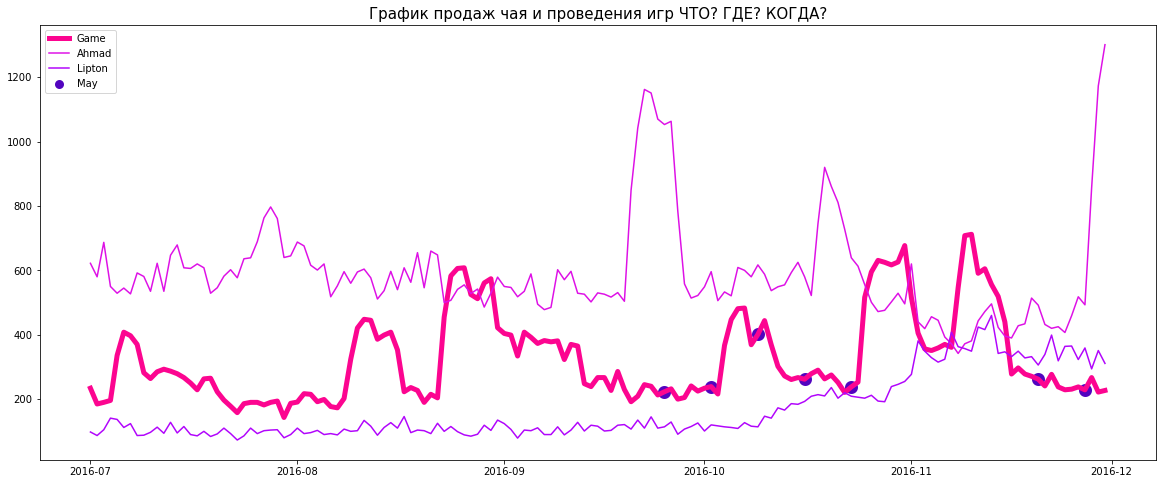

In [33]:
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots() 
x = tea_WWW.index
ax.scatter(x, tea_WWW['WWW'], c='#5204BF', lw=3) 
ax.plot(x, tea_WWW['ahmad'], c='#FC0590', lw=5) 
ax.plot(x, tea_WWW['lipton'], c='#DE11E6') 
ax.plot(x, tea_WWW['may'], c='#B105FC') 
ax.scatter(x, tea_WWW['WWW'], c='#5204BF', lw=7) 
ax.legend(['Game', 'Ahmad', 'Lipton','May'])
ax.set_title('График продаж чая и проведения игр ЧТО? ГДЕ? КОГДА?', fontsize=15)

На визуализации видно, что наблюдаяется некоторая корреляция между датами проведения игры и ростом продаж. Прирост продаж после рекламы бывает неоднородным по объему, идет с небольшим лагом (что логично, так как люди покупают чай не в день просмотра игры, а позднее).

Заметной корреляции между пиками и провалами продаж других брендов (Lipton и May) не наблюдается.

In [34]:
ahmad_tea = pivot_tea['ahmad'].to_frame()

In [35]:
#Decomposition
decomposition = seasonal_decompose(ahmad_tea, period=5, model='additive')

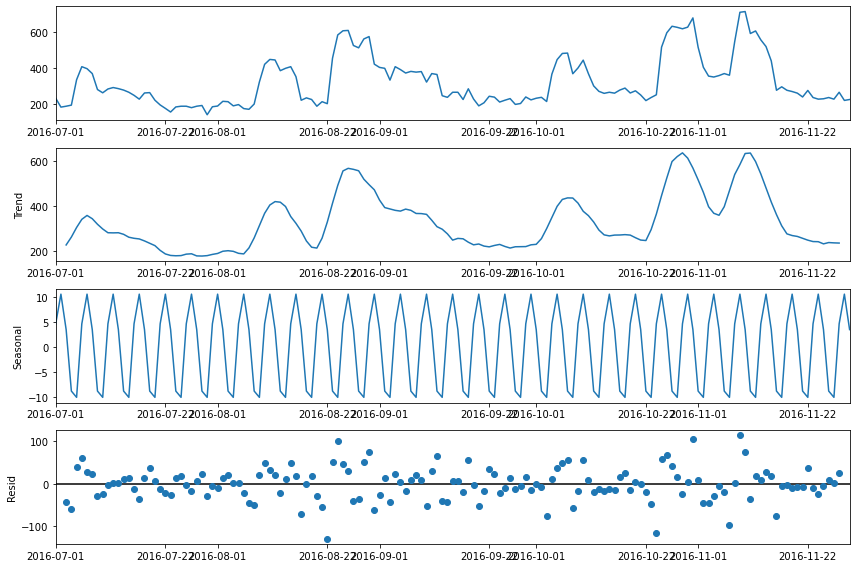

In [36]:
#Visualisation
plt.rcParams["figure.figsize"] = (12,8)
decomposition.plot()
plt.show()

Графики демонстрируют, что временной ряд не стационарен и не содержит повторяющихсях паттернов. Проверим это в ходе дальнейшего тестирования.

## Sales prediction

In [39]:
#Проведем тест Дики-Фуллера, чтобы определить стационарность временного ряда
test = adfuller(ahmad_tea['ahmad'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
    print ('Ряд не стационарен')
else:
    print ('Ряд стационарен')

adf:  -2.1957361074439214
p-value:  0.2077966421397376
Critical values:  {'1%': -3.476597917537401, '5%': -2.8818291230495543, '10%': -2.5775887982253085}
Ряд не стационарен


Посколькую ряд не стационарен, будем использовать модель SARIMAX.

In [40]:
ahmad_tea.head()

,ahmad
date,
2016-07-01,234.0
2016-07-02,185.0
2016-07-03,190.0
2016-07-04,196.0
2016-07-05,336.0


In [41]:
model=sm.tsa.statespace.SARIMAX(ahmad_tea['ahmad'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

D:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
D:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
D:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [42]:
ahmad_tea['forecast']=results.predict()
ahmad_tea.head()

,ahmad,forecast
date,,
2016-07-01,234.0,0.000000
2016-07-02,185.0,234.191838
2016-07-03,190.0,184.861093
2016-07-04,196.0,190.050764
2016-07-05,336.0,195.994265


In [43]:
#Anomaly classification
ahmad_tea['anomaly_precentage']=(ahmad_tea['ahmad']-ahmad_tea['forecast'])/ahmad_tea['ahmad'] * 100
ahmad_tea['anomaly_precentage'] = abs(ahmad_tea['anomaly_precentage'])

In [44]:
ahmad_tea.describe()

,ahmad,forecast,anomaly_precentage
count,153.000000,153.000000,153.000000
mean,327.045752,326.969693,15.270044
std,134.810703,140.459046,15.311594
min,143.000000,0.000000,0.062158
25%,227.000000,223.282440,5.556905
50%,275.000000,281.856780,10.012794
75%,399.000000,407.769246,20.156906
max,712.000000,733.589344,100.000000


In [45]:
anomaly = ahmad_tea[ahmad_tea.anomaly_precentage>40]
anomaly['is_anomaly'] = anomaly['ahmad']
anomaly = anomaly.is_anomaly.to_frame()
anomaly['date']=anomaly.index

<ipython-input-45-ae0862b981d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly['is_anomaly'] = anomaly['ahmad']


In [46]:
#Adding anomaly to frame
ahmad_tea = ahmad_tea.join(anomaly.set_index('date'), on='date')

Text(0.5, 1.0, 'Прогноз продаж Ahmad и график проведения игр Что? Где? Когда?')

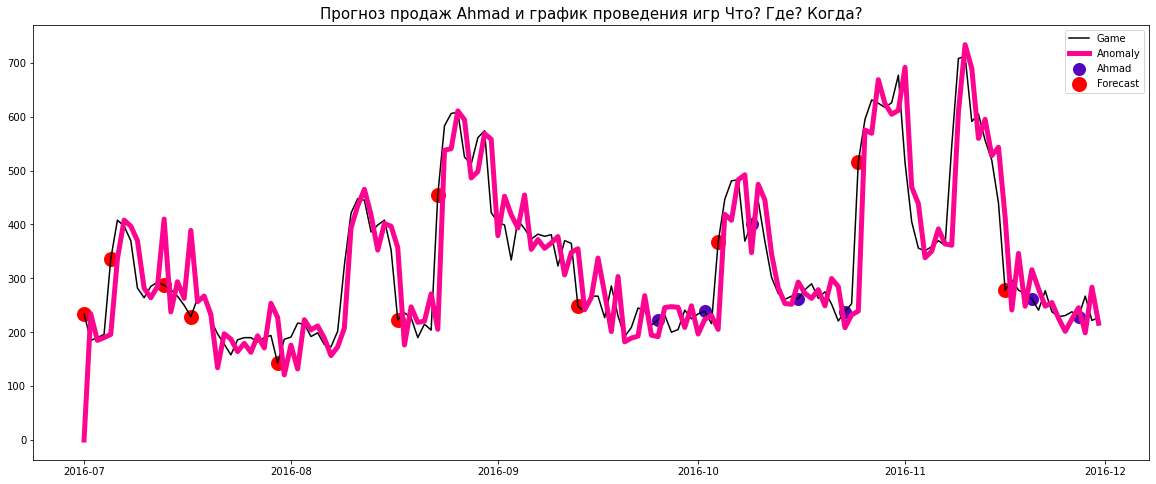

In [47]:
#Visualization
#Plotting
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots() 
x = tea_WWW.index
ax.scatter(x, tea_WWW['WWW'], c='#5204BF', lw=7)
ax.scatter(x, ahmad_tea['is_anomaly'], c='red', lw=9)
ax.plot(x, ahmad_tea['ahmad'], c='black') 
ax.plot(x, ahmad_tea['forecast'], c='#FC0590', lw=5) 
ax.legend(['Game', 'Anomaly', 'Ahmad', 'Forecast'])
ax.set_title('Прогноз продаж Ahmad и график проведения игр Что? Где? Когда?', fontsize=15)

Прогноз продаж чая Ахмад показывает, что только 2 из аномально высоких точек спроса имеют прямую корреляцию с проведением игры "Что? Где? Когда?"

Это говорит о том, что в октябре телереклама имела прямое влияние на повышение продаж, в других месяцах - нет.

### Boxplot

D:\DataScience\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ahmad'>

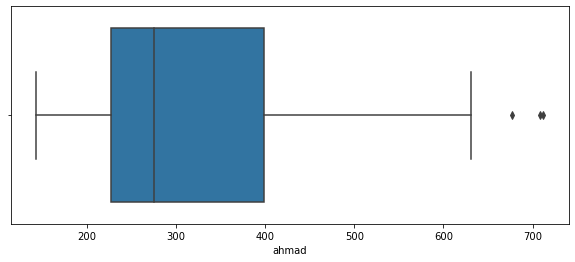

In [48]:
plt.rcParams["figure.figsize"] = (10,4)
sns.boxplot(ahmad_tea['ahmad'])

Анализ боксплота показывает, что продажи свыше примерно 620 единиц продукции в день можно рассматривать как выбросы (аномалии).

### Isolation Forest Clustering

<ipython-input-8-98636e522d6f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df['date'] = label_df.index


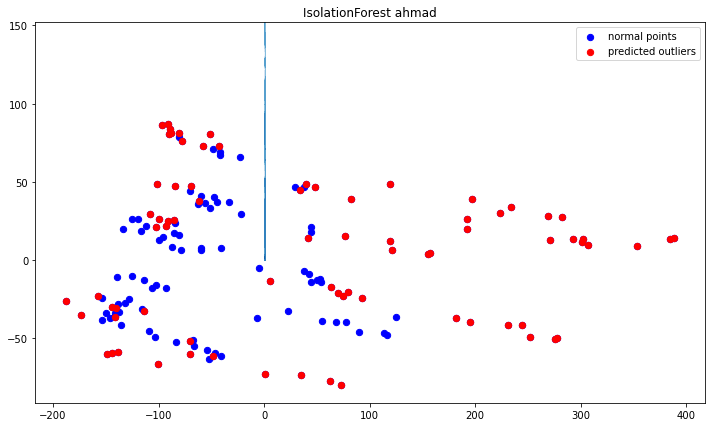

In [49]:
label = 'ahmad'
data = pivot_tea

get_cluster_plot(label, data)

<ipython-input-8-98636e522d6f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df['date'] = label_df.index


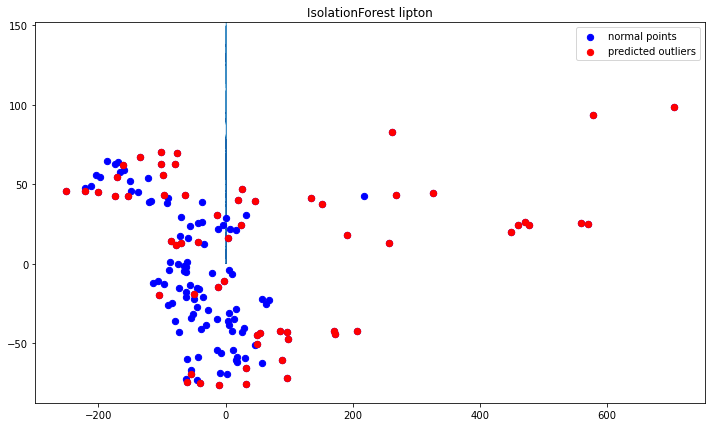

In [50]:
label = 'lipton'
data = pivot_tea

get_cluster_plot(label, data)

<ipython-input-8-98636e522d6f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df['date'] = label_df.index


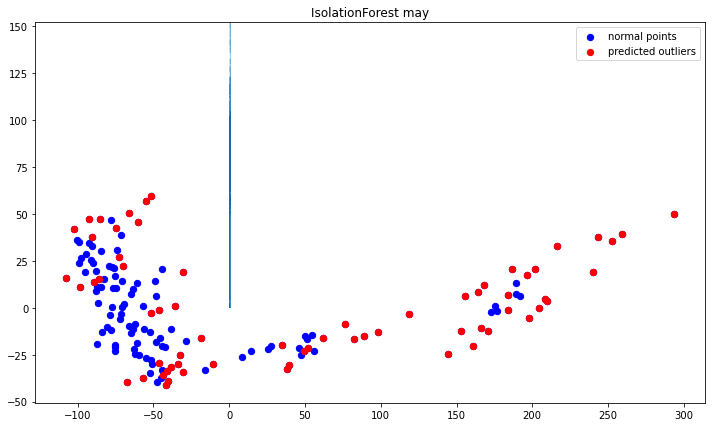

In [51]:
label = 'may'
data = pivot_tea

get_cluster_plot(label, data)

Сложно одназначно сказать повлияла ли реклама чая Ахмад в передаче Что? Где? Когда?
В данной задаче делался акцент на детектирование аномалий, а не на их связи с другими факторами что не даёт четко сделать вывод. Согласно проведенному исследованию, вличние реламы на продажи не стабтльно. Мы можем наблюдать на отложенный эфект повышения в октябре и декабре, но в части случаев нет.
Но важно отметить, что аномальное повышение спроса на чай Ахмад в предложенных данных действительно имеется.